# 1. Chọn bộ dữ liệu

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import plotly.graph_objects as go
import folium
import plotly.express as px
from scipy.interpolate import make_interp_spline, BSpline
from datetime import datetime, timedelta,date

In [12]:
#source https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset?select=time_series_covid_19_recovered.csv
confirmed = pd.read_csv('https://raw.githubusercontent.com/tanphuc0612/PTDLTM/master/data/time_series_covid_19_confirmed.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/tanphuc0612/PTDLTM/master/data/time_series_covid_19_deaths.csv')
recovered = pd.read_csv('https://raw.githubusercontent.com/tanphuc0612/PTDLTM/master/data/time_series_covid_19_recovered.csv')
all_cases = pd.read_csv('https://raw.githubusercontent.com/tanphuc0612/PTDLTM/master/data/covid_19_data.csv',parse_dates = ['ObservationDate','Last Update'])
#tổng hợp số liệu mới nhất từ source http://datatopics.worldbank.org/universal-health-coverage/coronavirus/?fbclid=IwAR2hAy_tY9F17bHo_DFScCxwXNU-bdb_4nx5GSIqdThCTiwp4zMsUxew23I
some_information = pd.read_csv('https://raw.githubusercontent.com/tanphuc0612/PTDLTM/master/data/data.csv')

In [13]:
confirmed.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,31238,31517,31836,32022,32324,32672,32951,33190,33384,33594,33908,34194,34366,34451,34455,34740,34994,35070,35229,35301,35475,35526,35615,35727,35928,35981,36036,36157,36263,36368,36471,36542,36675,36710,36710,36747,36782,36829,36896,37015
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2466,2535,2580,2662,2752,2819,2893,2964,3038,3106,3188,3278,3371,3454,3571,3667,3752,3851,3906,4008,4090,4171,4290,4358,4466,4570,4637,4763,4880,4997,5105,5197,5276,5396,5519,5620,5750,5889,6016,6151


In [14]:
deaths.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,733,746,774,807,819,826,864,898,920,936,957,971,994,1010,1012,1048,1094,1113,1147,1164,1181,1185,1186,1190,1211,1225,1248,1259,1269,1270,1271,1271,1272,1283,1284,1288,1288,1294,1298,1307
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,58,62,65,69,72,74,76,79,81,83,83,85,89,93,95,97,101,104,107,111,112,113,117,120,123,128,134,138,144,148,150,154,157,161,166,172,176,182,188,189


In [15]:
recovered.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13934,14131,15651,16041,17331,19164,19366,20103,20179,20700,20847,20882,21135,21216,21254,21454,22456,22824,23151,23273,23634,23741,23741,23924,24550,24602,24793,25180,25198,25358,25389,25471,25509,25509,25510,25669,25669,25742,25840,25903
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1438,1459,1516,1559,1592,1637,1657,1702,1744,1791,1832,1875,1881,1946,2014,2062,2091,2137,2214,2264,2311,2352,2397,2463,2523,2608,2637,2682,2745,2789,2830,2883,2952,2961,3018,3031,3031,3123,3155,3227


In [16]:
some_information.head(2)

,Country Name,"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)",People using at least basic drinking water services (% of population),"Hospital beds (per 1,000 people)","Nurses and midwives (per 1,000 people)","Smoking prevalence, total (ages 15+) %",Diabetes prevalence (% of population ages 20 to 79),People with basic handwashing facilities including soap and water (% of population),Current health expenditure (% of GDP),Current health expenditure per capita (current US$),Out-of-pocket expenditure (% of current health expenditure),"Life expectancy at birth, total (years)",Population ages 65 and above (% of total population)
0,Aruba,NaN,NaN,97.869023,NaN,NaN,28.7,11.6,NaN,NaN,NaN,NaN,76.152,14.058355
1,Afghanistan,29.8,36.4,67.064623,0.5,0.1755,33.5,9.2,37.746032,11.777194,67.12265,75.482577,64.486,2.615794


In [17]:
all_cases.head(2)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0


# 2. Tiền xử lý dữ liệu

In [18]:
confirmed = confirmed.replace(np.nan, '')
deaths = deaths.replace(np.nan, '')
recovered = recovered.replace(np.nan, '')
all_cases = all_cases.replace(np.nan, '')
all_cases = all_cases.drop(['SNo', 'Last Update'], axis=1)
convert_dict = {'Confirmed': int, 
                'Deaths': int,
                'Recovered': int,
                } 
all_cases = all_cases.astype(convert_dict) 
all_cases.dtypes
all_cases.head(2)

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1,0,0
1,2020-01-22,Beijing,Mainland China,14,0,0


# 3. Tổng quan về tình hình dịch bệnh thế giới

#Tổng số ca nhiễm toàn thế giới

In [19]:
last_date_cases = all_cases[all_cases['ObservationDate'] == all_cases['ObservationDate'].max()]
total_confirmed = np.sum(last_date_cases['Confirmed'])
total_deaths = np.sum(last_date_cases['Deaths'])
total_recovered = np.sum(last_date_cases['Recovered'])
total_mortality_rate = total_deaths / total_confirmed * 100
total_recover_rate = total_recovered / total_confirmed * 100

data = {
    'Confirmed': [total_confirmed],
    'Deaths': [total_deaths],
    'Recovered': [total_recovered],
    'Mortality Rate %': [total_mortality_rate],
    'Recover Rate %': [total_recover_rate]
}
df_total = pd.DataFrame(data)
df_total.style.hide_index().background_gradient(cmap='cividis', axis=1)\
.format("{:.4f}",subset=["Mortality Rate %", "Recover Rate %"])

Confirmed,Deaths,Recovered,Mortality Rate %,Recover Rate %
19378036,721324,11737927,3.7224,60.5734


#Số ca nhiễm trên từng quốc gia

In [20]:
country_cases =last_date_cases.groupby('Country/Region').sum().reset_index().sort_values('Confirmed',ascending=[False])
country_cases['Death Rate'] = country_cases['Deaths'] / country_cases['Confirmed'] * 100
country_cases['Recovery Rate'] = country_cases['Recovered'] / country_cases['Confirmed'] * 100

# remove unnecessary columns
# add different gradient color to each column
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# https://pandas.pydata.org/pandas-docs/version/0.18/generated/pandas.formats.style.Styler.format.html
country_cases.style.hide_index()\
.background_gradient(cmap='Blues',subset=["Confirmed"])\
.background_gradient(cmap='Reds',subset=["Deaths"])\
.background_gradient(cmap='Greens',subset=["Recovered"])\
.background_gradient(cmap='OrRd',subset=["Death Rate"])\
.background_gradient(cmap='PuBu',subset=["Recovery Rate"])\
.format("{:.4f}",subset=["Death Rate", "Recovery Rate"])

Country/Region,Confirmed,Deaths,Recovered,Death Rate,Recovery Rate
US,4941755,161347,1623870,3.2650,32.8602
Brazil,2962442,99572,2272299,3.3611,76.7036
India,2088611,42518,1427005,2.0357,68.3232
Russia,875378,14698,682278,1.6790,77.9410
South Africa,545476,9909,394759,1.8166,72.3696
Mexico,469407,51311,370098,10.9310,78.8437
Peru,463875,20649,314332,4.4514,67.7622
Chile,368825,9958,342168,2.6999,92.7725
Colombia,367204,12250,198495,3.3360,54.0558
Iran,322567,18132,279724,5.6212,86.7181


#Top 10 quốc gia có số ca nhiễm lớn nhất

In [21]:
top10_confirmed = country_cases.sort_values('Confirmed').tail(10)
top10_confirmed = top10_confirmed.sort_values('Confirmed',ascending=False)
fig = go.Figure(data=[
    go.Bar(name='Confirmed', x=top10_confirmed['Country/Region'], y=top10_confirmed['Confirmed'], 
           text=top10_confirmed['Confirmed'], texttemplate='%{text:.2s}', textposition='outside'),
    go.Bar(name='Deaths', x=top10_confirmed['Country/Region'], y=top10_confirmed['Deaths'], 
           text=top10_confirmed['Deaths'], texttemplate='%{text:.2s}', textposition='outside'),
    go.Bar(name='Recovered', x=top10_confirmed['Country/Region'], y=top10_confirmed['Recovered'], 
           text=top10_confirmed['Recovered'], texttemplate='%{text:.2s}', textposition='outside'),
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.update_layout(margin={"r":0,"l":0,"b":0, "t":0})
fig.show()

# 4. Phân tích sự gia tăng số ca nhiễm toàn cầu theo thời gian

In [22]:
temp_df = all_cases.groupby(['ObservationDate'])['Confirmed', 'Deaths','Recovered'].sum()
global_cases_time_series= temp_df.reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=global_cases_time_series['ObservationDate'], y=global_cases_time_series['Confirmed'], 
                         mode='lines', name='Confirmed'))
fig.add_trace(go.Scatter(x=global_cases_time_series['ObservationDate'], y=global_cases_time_series['Deaths'], 
                         mode='lines', name='Deaths'))
fig.add_trace(go.Scatter(x=global_cases_time_series['ObservationDate'], y=global_cases_time_series['Recovered'], 
                         mode='lines', name='Recovered'))
fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'Time Series - Confirmed, Deaths & Recovered Cases'
    )
fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        #bgcolor="LightSteelBlue",
        bordercolor="silver",
        borderwidth=1
    )
)
fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()

In [24]:
global_cases_daily_time_series = temp_df.diff().fillna(temp_df).reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=global_cases_daily_time_series['ObservationDate'], y=global_cases_daily_time_series['Confirmed'], 
                         mode='lines', name='Confirmed'))
fig.add_trace(go.Scatter(x=global_cases_daily_time_series['ObservationDate'], y=global_cases_daily_time_series['Deaths'], 
                         mode='lines', name='Deaths'))
fig.add_trace(go.Scatter(x=global_cases_daily_time_series['ObservationDate'], y=global_cases_daily_time_series['Recovered'], 
                         mode='lines', name='Recovered'))
fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'Time Series - Confirmed, Deaths & Recovered [Daily Cases]'
    )
fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        #bgcolor="LightSteelBlue",
        bordercolor="silver",
        borderwidth=1
    )
)
fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()

In [25]:
temp_df['Recovery Rate'] = np.round(temp_df['Recovered'] / temp_df['Confirmed'] * 100, 2)
temp_df['Death Rate'] = np.round(temp_df['Deaths'] / temp_df['Confirmed'] * 100, 2)

In [26]:
global_rate = temp_df.reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=global_rate['ObservationDate'], y=global_rate['Recovery Rate'], 
                         mode='lines', name='Recovery Rate'))
fig.add_trace(go.Scatter(x=global_rate['ObservationDate'], y=global_rate['Death Rate'], 
                         mode='lines', name='Death Rate'))
fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'Time Series - Death Rate & Recovery Rate'
    )
fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        #bgcolor="LightSteelBlue",
        bordercolor="silver",
        borderwidth=1
    )
)
fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()

#Kết luận:
- Trong giai đoạn đầu của dịch bệnh (đầu năm 2020 đến giữa tháng 3/2020) tốc độ lây lan của dịch bệnh trên toàn cầu khá chậm, chủ yếu ở Trung Quốc nên các nước chủ quan
- Chính vì sự chủ quan mà từ giữa tháng 3/2020 dịch bệnh lây lan với tốc độ rất nhanh và đến hiện tại vẫn không ngừng tăng lên.
- Hiện tại dịch bệnh đang hoành hành và không thể kiểm soát.

# 5. Các vấn đề liên quan đến sự kiểm soát dịch bệnh

In [27]:
data = country_cases.set_index('Country/Region').join(some_information.set_index('Country Name'))
data.head(2)

,Confirmed,Deaths,Recovered,Death Rate,Recovery Rate,"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)",People using at least basic drinking water services (% of population),"Hospital beds (per 1,000 people)","Nurses and midwives (per 1,000 people)","Smoking prevalence, total (ages 15+) %",Diabetes prevalence (% of population ages 20 to 79),People with basic handwashing facilities including soap and water (% of population),Current health expenditure (% of GDP),Current health expenditure per capita (current US$),Out-of-pocket expenditure (% of current health expenditure),"Life expectancy at birth, total (years)",Population ages 65 and above (% of total population)
Country/Region,,,,,,,,,,,,,,,,,,
US,4941755,161347,1623870,3.264974,32.860188,14.6,5.2,99.269192,2.9,14.548,NaN,10.8,NaN,17.061269,10246.138672,10.992922,78.539024,16.209606
Brazil,2962442,99572,2272299,3.361146,76.703578,16.6,13.9,98.193393,2.2,10.119,NaN,10.4,NaN,9.467477,928.799316,27.455494,75.672000,9.251608


Text(0.5, 1.0, 'Deaths rate with Population ages 65 and above')

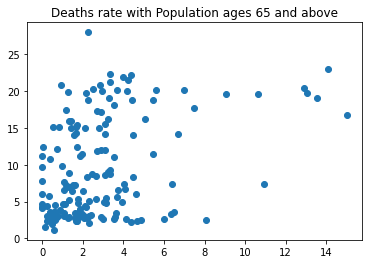

In [28]:
age_65 = plt.scatter(data['Death Rate'], data['Population ages 65 and above (% of total population)']);
plt.title('Deaths rate with Population ages 65 and above')


Text(0.5, 1.0, 'Life_expectancy with death rate')

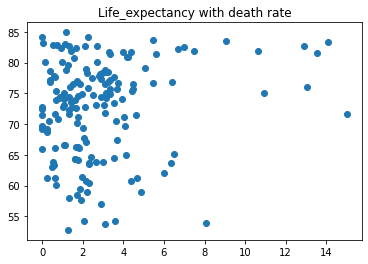

In [29]:
Life_expectancy = plt.scatter(data['Death Rate'], data['Life expectancy at birth, total (years)']);
plt.title('Life_expectancy with death rate')

Text(0.5, 1.0, 'Current_health_expenditure with death rate')

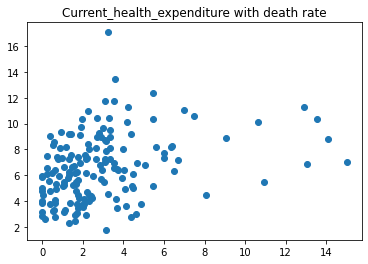

In [30]:
Current_health_expenditure = plt.scatter(data['Death Rate'], data['Current health expenditure (% of GDP)']);
plt.title('Current_health_expenditure with death rate')

* Các nước có tỉ lệ tử vong cao có phần trăm dân số trên 65 tuổi cao. Qua đó 
COVID người già nguy hiểm nhất, đặc biệt là các nước có dân số già cao.
* Các nước đầu tư y tế có xu hướng dân số già cho nên tỉ lệ tử vong cao so với các nước không đầu tư vào y tế.

# 6. Dự đoán tình hình dịch bệnh trong tương lai

#Khai báo thư viện

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Hàm vẽ biểu đồ

In [32]:
def plot_predictions(x, y, pred, name, algo_name, color):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y= y, 
                            mode='lines', name=name))
    fig.add_trace(go.Scatter(x=future_forecast_dates, y= pred, 
                            mode='lines', name=algo_name))
    fig.update_layout(
            xaxis_title="Days Since 1/22/2020",
            yaxis_title="Number of Cases",
            title = 'Worldwide Coronavirus Cases Over Time'
        )
    fig.update_layout(
        legend=dict(
            x=0,
            y=1,
            traceorder="normal",
            #bgcolor="LightSteelBlue",
            bordercolor="silver",
            borderwidth=1
        )
    )
    fig.update_layout(margin={"r":0,"l":0,"b":0})
    fig.show()

#Xử lý dữ liệu

In [33]:
cols = confirmed.keys()
dates = confirmed.loc[:, cols[4]:cols[-1]].keys()
world_cases = []
total_deaths = []
total_recovered = []
total_active = []

for i in dates:
  confirmed_sum = confirmed[i].sum()
  death_sum = deaths[i].sum()
  recovered_sum = recovered[i].sum()

  world_cases.append(confirmed_sum)
  total_deaths.append(death_sum)
  total_recovered.append(recovered_sum)

In [34]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [35]:
days_in_future = 60
future_forecast = np.array([i for i in range(len(dates) + days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[:-days_in_future]

In [36]:
start = '1/22/2020'
start_date = datetime.strptime(start, '%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
  future_forecast_dates.append((start_date + timedelta(days=i)).strftime('%m/%d/%Y'))

In [37]:
x_train_confirmed, x_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.05, shuffle=False)
x_train_deaths, x_test_deaths, y_train_deaths, y_test_deaths = train_test_split(days_since_1_22, total_deaths, test_size=0.05, shuffle=False)
x_train_recovered, x_test_recovered, y_train_recovered, y_test_recovered = train_test_split(days_since_1_22, total_recovered, test_size=0.05, shuffle=False)

In [38]:
len(world_cases)

199

In [39]:
len(y_train_deaths)


189

#Sử dụng phương pháp polynomial regression dự đoán số ca nhiễm trong 60 ngày tới

In [40]:
# transform out data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_x_train_confirmed = poly.fit_transform(x_train_confirmed)
poly_x_test_confirmed = poly.fit_transform(x_test_confirmed)
poly_future_forecast = poly.fit_transform(future_forecast)

MAE: 531866.2825008146
MSE: 285452466918.86194


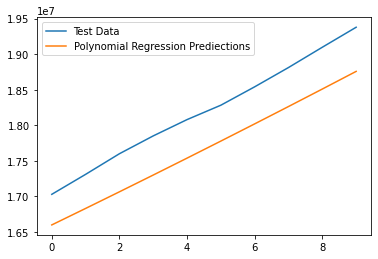

In [41]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_x_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_x_test_confirmed)
linear_pred = linear_model.predict(poly_future_forecast)
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Prediections'])
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:', mean_squared_error(test_linear_pred, y_test_confirmed))

In [42]:
plot_predictions(future_forecast_dates[0:-days_in_future], world_cases.reshape(1, -1)[0], linear_pred.reshape(1, -1)[0], 'Confirmed Case', 'Polynomial Regression Predictions', 'red')

#Sử dựng phương pháp SVM dự đoán số ca nhiễm trong 60 ngày tới

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MAE: 5118321.209969968
MSE: 27039987905665.1


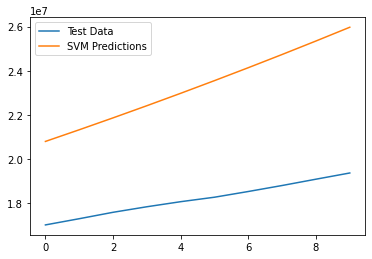

In [43]:
svm_confirmed = SVR(shrinking=True, kernel='poly', gamma=0.01, epsilon=1, degree=5, C=0.1)
svm_confirmed.fit(x_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forecast)
svm_test_pred = svm_confirmed.predict(x_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:', mean_squared_error(svm_test_pred, y_test_confirmed))

In [44]:
plot_predictions(future_forecast_dates[0:-days_in_future], world_cases.reshape(1, -1)[0], svm_pred.reshape(1, -1)[0], 'Confirmed Case', 'SVM Predictions', 'red')


#Sử dựng phương pháp polynomial regression dự đoán số người hồi phục và tử vong trong 60 ngày tới

In [45]:
# transform out data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_x_train_deaths = poly.fit_transform(x_train_deaths)
poly_x_test_deaths = poly.fit_transform(x_test_deaths)

poly = PolynomialFeatures(degree=3)
poly_x_train_recovered = poly.fit_transform(x_train_recovered)
poly_x_test_recovered = poly.fit_transform(x_test_recovered)

In [46]:
# polynomial regression deaths
deaths_linear_model = LinearRegression(normalize=True, fit_intercept=False)
deaths_linear_model.fit(poly_x_train_deaths, y_train_deaths)
deaths_linear_pred = deaths_linear_model.predict(poly_future_forecast)

In [47]:
# polynomial regression deaths
recovered_linear_model = LinearRegression(normalize=True, fit_intercept=False)
recovered_linear_model.fit(poly_x_train_recovered, y_train_recovered)
recovered_linear_pred = recovered_linear_model.predict(poly_future_forecast)

#Sử dựng phương pháp SVM dự đoán số người hồi phục và tử vong trong 60 ngày tới

In [48]:
# SVM deaths
svm_deaths = SVR(shrinking=True, kernel='poly', gamma=0.01, epsilon=1, degree=5, C=0.1)
svm_deaths.fit(x_train_deaths, y_train_deaths)
deaths_svm_pred = svm_deaths.predict(future_forecast)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [49]:
# SVM recovered
svm_recovered = SVR(shrinking=True, kernel='poly', gamma=0.01, epsilon=1, degree=5, C=0.1)
svm_recovered.fit(x_train_recovered, y_train_recovered)
recovered_svm_pred = svm_recovered.predict(future_forecast)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



#Biểu diễn số ca nhiễm, hồi phục và tử vong trong 60 ngày tới _ Polynomial Regression Prediections

In [50]:
linear_pred = linear_pred.reshape(1, -1)[0]
deaths_linear_pred = deaths_linear_pred.reshape(1, -1)[0]
recovered_linear_pred = recovered_linear_pred.reshape(1, -1)[0]
future_dates = future_forecast_dates[-days_in_future:]
future_forecast_confirmed_predict = np.round(linear_pred[-days_in_future:])
future_forecast_deaths_predict = np.round(deaths_linear_pred[-days_in_future:])
future_forecast_recovered_predict = np.round(recovered_linear_pred[-days_in_future:])

fig = go.Figure()
fig.add_trace(go.Scatter(x=future_dates, y= future_forecast_confirmed_predict, 
                         mode='lines', name='Confirmed Case'))
fig.add_trace(go.Scatter(x=future_dates, y= future_forecast_deaths_predict, 
                         mode='lines', name='Deaths Case'))
fig.add_trace(go.Scatter(x=future_dates, y= future_forecast_recovered_predict, 
                         mode='lines', name='Recovered Case'))
fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'Time Series - Worldwide Confirmed Case, Deaths Case, Recovered Case Polynomial Regression Prediections'
    )
fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        #bgcolor="LightSteelBlue",
        bordercolor="silver",
        borderwidth=1
    )
)
fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()

#Biểu diễn số ca nhiễm, hồi phục và tử vong trong 60 ngày tới _ SVM

In [51]:
svm_pred = svm_pred.reshape(1, -1)[0]
deaths_svm_pred = deaths_svm_pred.reshape(1, -1)[0]
recovered_svm_pred = recovered_svm_pred.reshape(1, -1)[0]
future_dates = future_forecast_dates[-days_in_future:]
future_forecast_confirmed_predict = np.round(svm_pred[-days_in_future:])
future_forecast_deaths_predict = np.round(deaths_svm_pred[-days_in_future:])
future_forecast_recovered_predict = np.round(recovered_svm_pred[-days_in_future:])

fig = go.Figure()
fig.add_trace(go.Scatter(x=future_dates, y= future_forecast_confirmed_predict, 
                         mode='lines', name='Confirmed Case'))
fig.add_trace(go.Scatter(x=future_dates, y= future_forecast_deaths_predict, 
                         mode='lines', name='Deaths Case'))
fig.add_trace(go.Scatter(x=future_dates, y= future_forecast_recovered_predict, 
                         mode='lines', name='Recovered Case'))
fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'Time Series - Worldwide Confirmed Case, Deaths Case, Recovered Case SVM Prediections'
    )
fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        #bgcolor="LightSteelBlue",
        bordercolor="silver",
        borderwidth=1
    )
)
fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()

#Phương pháp Polynomial Regression Prediections cho kết quả chính xác hơn. Và nếu tình hình dịch bệnh vẫn diễn biến như vậy thì trong vòng 60 ngày nữa số ca nhiễm sẽ tăng lên gấp đôi (gần 38 triệu người).